# Medford Disaster Router
<br>
<b>Contributors: Michael Ruggiero, Cengiz Imga, Dali Souayah

# Index

1. [Problem Statement](#PS)
2. [Data Preparation](#Data)
    1. [Major Road Functions](#MRF)
    2. [Routing](#Route)
    3. [Disaster Radius](#Dis)
    4. [Edge Manipulation and Visualizations](#EM)
3. [Dataset Creation](#Maker)
    1. [Data Cleaning](#Clean)
    2. [Statistics](#Stats)

In [1]:
# Function imports
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

ox.config(use_cache=True, log_console=True)
ox.__version__

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## 1. Problem Statement <a id = "PS"></a>

1) Build a NLP model that identifies peaks in twitter (or other social media) that would hint to road closures or disasters locations with Google maps

2) translate those identified locations into flags in a map

3) reflect the affected roads into a map in red color

4) produce a map of valid rescue roads/escape routes

## 2. Data Collection/Import Medford <a id = "Data"></a>

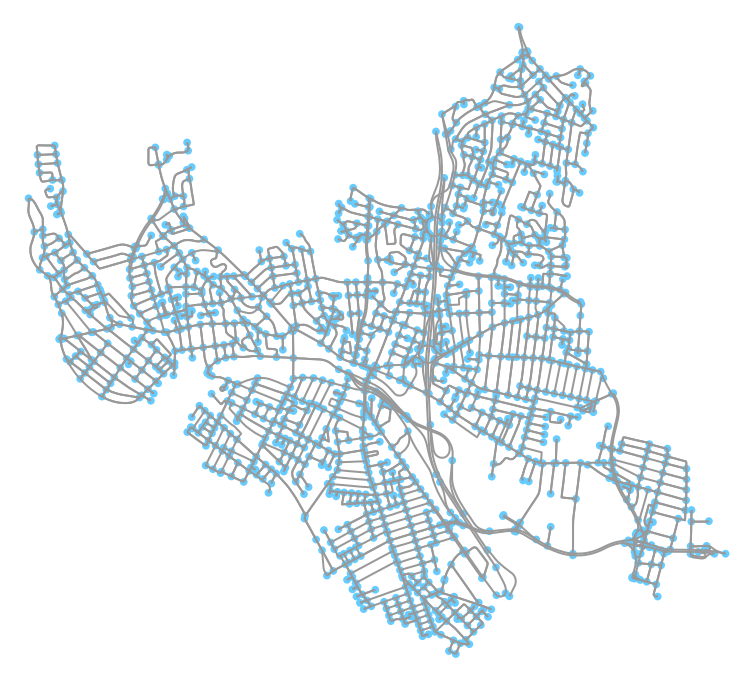

In [2]:
# get a graph for some city
place = {'city' : 'Medford',
         'state' : 'MA',
         'country' : 'USA'}
medford = ox.graph_from_place(place, network_type='drive')
fig, ax = ox.plot_graph(medford)

In [3]:
# what sized area does our network cover in square meters?
medford_proj = ox.project_graph(medford)
nodes_proj = ox.graph_to_gdfs(medford_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print(graph_area_m)

# show basic stats about the network
medford_stats = ox.basic_stats(medford_proj, 
                               area=graph_area_m, 
                               clean_intersects=True,
                               circuity_dist='euclidean')

# medford_stats = ox.extended_stats(medford_proj, ecc=True, bc=True, cc=True)

pd.DataFrame(medford_stats).set_index("streets_per_node_counts")

21010917.099306576


,n,m,k_avg,intersection_count,streets_per_node_avg,streets_per_node_proportion,edge_length_total,edge_length_avg,street_length_total,street_length_avg,street_segments_count,node_density_km,intersection_density_km,edge_density_km,street_density_km,circuity_avg,self_loop_proportion,clean_intersection_count,clean_intersection_density_km
streets_per_node_counts,,,,,,,,,,,,,,,,,,,
0,1569,3862,4.922881,1361,2.905672,0.000000,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
208,1569,3862,4.922881,1361,2.905672,0.132569,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
4,1569,3862,4.922881,1361,2.905672,0.002549,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
1094,1569,3862,4.922881,1361,2.905672,0.697259,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
254,1569,3862,4.922881,1361,2.905672,0.161887,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765
9,1569,3862,4.922881,1361,2.905672,0.005736,397167.386,102.83982,239165.907,106.485266,2246,74.675465,64.775849,18902.905767,11382.93516,1.0391,0.002071,1115,53.06765


In [4]:
# Edge and Node projection
nodes_med, edges_med = ox.graph_to_gdfs(medford, nodes=True, edges=True)

In [5]:
nodes_med.head(2)

,highway,osmid,ref,x,y,geometry
66478081,turning_circle,66478081,NaN,-71.100780,42.429287,POINT (-71.1007798 42.4292871)
1095962629,traffic_signals,1095962629,NaN,-71.110312,42.415123,POINT (-71.1103119 42.4151234)


In [6]:
nodes_med.shape

(1569, 6)

## 2a. Major Roads Functions<a id = "MRF"></a>

In [7]:
#Functions built for this project
import graph_functions as gf

4     	 nodes in        MA 16;MA 38 	 colored 	 mediumseagreen
96    	 nodes in              MA 38 	 colored 	 sienna
12    	 nodes in               I 93 	 colored 	 mediumseagreen
76    	 nodes in              MA 28 	 colored 	 darkslateblue
5     	 nodes in        MA 38;MA 60 	 colored 	 mediumpurple
143   	 nodes in              MA 60 	 colored 	 rosybrown
51    	 nodes in              MA 16 	 colored 	 slateblue

major road map for region


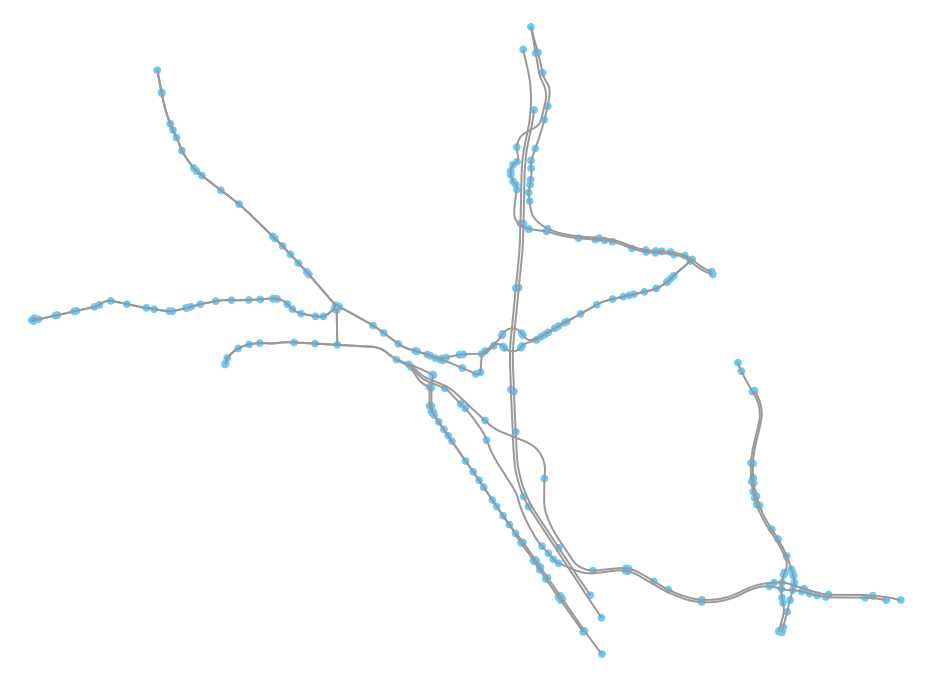

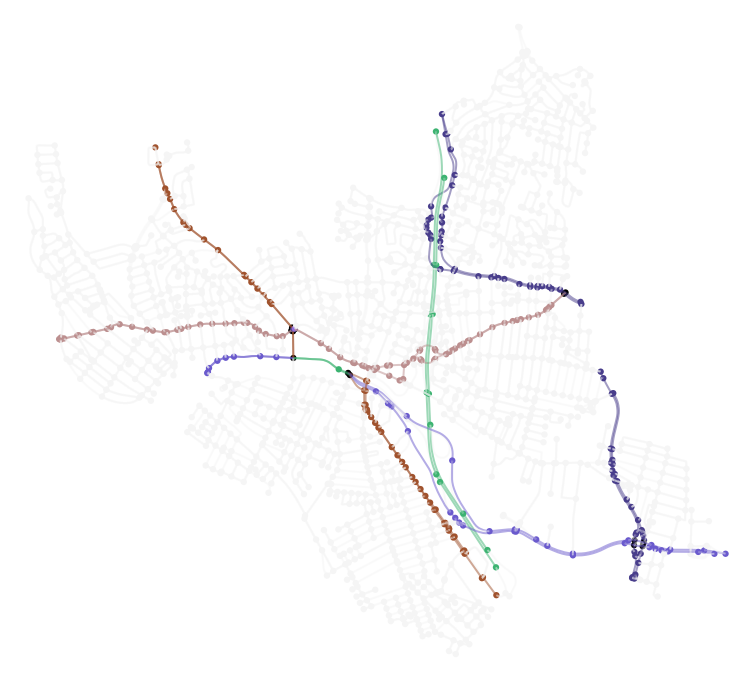

In [8]:
medford_data = gf.node_roader(medford)

In [10]:
medford_data.keys()

dict_keys(['graph', 'edges', 'nodes', 'major_roads', 'major_intersections', 'color_dictionary', 'edge_color', 'node_color'])

In [11]:
edges_med, nodes_med, medford = medford_data["edges"], medford_data["nodes"], medford_data["graph"]

In [12]:
nodes_med.major_inter.value_counts()

0    1286
1     268
3       6
4       4
6       3
2       2
Name: major_inter, dtype: int64

In [ ]:
#Long/Lat information
nodes_med[["x","y"]].describe()

In [ ]:
nodes_med.head()

## 2b. Routing<a id = "Route"></a>

In [ ]:
#A function to generate a random lat/long point
gf.random_point()

In [ ]:
random_point_A = gf.random_point()
random_point_B = gf.random_point()

# get the nearest network node to each random point
orig_node = ox.get_nearest_node(medford, random_point_A)
dest_node = ox.get_nearest_node(medford, random_point_B)

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(medford, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(medford, route, node_size=0)

In [ ]:
# Length of route in meters
nx.shortest_path_length(medford, orig_node, dest_node, weight='length')

In [ ]:
# Absolute Distance between two nodes (as the crow flies)
ox.great_circle_vec(medford.node[orig_node]['y'], medford.node[orig_node]['x'],
                    medford.node[dest_node]['y'], medford.node[dest_node]['x'])

## 2c. Disaster Radius<a id = "Dis"></a>

In [ ]:
nodes_med[["y","x"]].sample(1).values[0]

In [ ]:
#returns a graphs object of a disater
disaster = gf.disaster_generator(nodes_med, 0,1500)

In [ ]:
nodes_dis, edges_dis = ox.graph_to_gdfs(disaster)

In [ ]:
#Set Colors
ec = ['lightcoral' if i in disaster.edges() else 'green' for i in medford.edges()]
nc = ['red' if i in disaster.nodes() else 'blue' for i in medford.nodes()]

#Plot energency grid
ox.plot_graph(medford, node_size=15, node_color = nc ,edge_color=ec)

In [ ]:
medford_disaster = gf.road_kill(disaster, nodes_med, edges_med)

## 2d. Edge Manipulation and Visualizations<a id = "EM"></a>


In [ ]:
# get the boundary polygons for neighboring cities, save as shapefile, project to UTM, and plot
place_names = ['Medford, MA, USA', 
               'Arlington, MA, USA',
               'Somerville, MA, USA',
               'Malden, MA, USA',
#                'Melrose, MA, USA',
               'Winchester, MA, USA',
               'Stoneham, MA, USA',
               'Everett, MA, USA',
              ]
medford_area = ox.gdf_from_places(place_names)
fig, ax = ox.plot_shape(medford_area)

In [ ]:
# highlight one-way roads
ec = ['r' if data['oneway'] else 'b' for u, v, key, data in medford.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(medford, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.5)

In [ ]:
#Neighboor hoods buffered
neigboors_buffered = ox.gdf_from_places(place_names, gdf_name='neighboors', buffer_dist=250)
fig, ax = ox.plot_shape(neigboors_buffered, alpha=0.7)

## 3. Data Creation <a id = "Maker"></a>

In [ ]:
# DF builder of start/end nodes with long/lat and times 
router = gf.random_zone_picker(nodes_med, 1_000)
#router.to_csv("routes_with_zones.csv")

In [ ]:
router.head()

In [ ]:
# network from address, including only nodes within 6.5km along the network from city hall
neighbor = ox.graph_from_address(address='85 George P. Hassett Drive,\
                                    Medford, MA 02155',
                                    distance=6500, distance_type='network', network_type='drive')

# you can project the network to UTM (zone calculated automatically)
neighbor_projected = ox.project_graph(neighbor)

In [ ]:
# Edge and Node projection
nodes_area, edges_area = ox.graph_to_gdfs(neighbor_projected,
                                        nodes=True,
                                        edges=True)

nc = ['blue' if i in medford.nodes() else 'green' for i in neighbor.nodes()]

ox.plot_graph(neighbor,
              node_size=15,
              node_color = nc);

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(neighbor, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(neighbor, route, node_size=0)

In [ ]:
neighbor_data = gf.node_roader(neighbor)

In [ ]:
nodes_area, edges_area, neighborhood = neighbor_data["nodes"], neighbor_data["edges"], neighbor_data["graph"]

In [ ]:
neighborhood[65355776][65348030]

In [ ]:
edges_area.head()

In [ ]:
edges_area.color.value_counts()

In [ ]:
major_nodes_area = nodes_area[nodes_area.major != "minor"].copy()
major_edges_area = edges_area[edges_area.ref != "minor"].copy()

major_nodes_area.reset_index(inplace = True)
major_edges_area.reset_index(inplace = True)

minor_nodes_area = nodes_area[nodes_area.major == "minor"]

kill = np.asarray(minor_nodes_area.osmid.values)

major_roads = ox.gdfs_to_graph(nodes_area,
                     major_edges_area)

for i in kill:
    major_roads.remove_node(i)

ox.plot_graph(major_roads);

In [ ]:
def intersection(graph):
    """Produces a dictionary for all of the nodes based on degree from a graph"""
    inter_dict = {}
    degree_list = nx.degree_histogram(graph)
    
    for i in range(len(degree_list)):
        node_list = []
        for j in graph.nodes():
            if nx.degree(graph,j) == i:
                node_list.append(j)

        inter_dict[i] = node_list
            
    return inter_dict

def major_map(nodes_df,edges_df):
    
    m_nodes_df = nodes_df[nodes_df.major != "minor"].copy()
    m_edges_df = edges_df[edges_df.ref != "minor"].copy()

    minor_nodes = nodes_df[nodes_df.major == "minor"]

    kill = np.asarray(minor_nodes.osmid.values)

    major_roads = ox.gdfs_to_graph(nodes_df,
                                   m_edges_df)

    for i in kill:
        major_roads.remove_node(i)

    ox.plot_graph(major_roads);
    
    return intersection(major_roads)

In [ ]:
a = major_map(nodes_area, edges_area)

In [ ]:
a.keys()

In [ ]:
major_nodes_area = nodes_area[nodes_area.major != "minor"].copy()
major_edges_area = edges_area[edges_area.ref != "minor"].copy()

major_nodes_area.reset_index(inplace = True)
major_edges_area.reset_index(inplace = True)

minor_nodes_area = nodes_area[nodes_area.major == "minor"]

kill = np.asarray(minor_nodes_area.osmid.values)

major_roads = ox.gdfs_to_graph(nodes_area,
                     major_edges_area)

for i in kill:
    major_roads.remove_node(i)

ox.plot_graph(major_roads);

In [ ]:
nx.degree_histogram(major_roads)

In [ ]:
def intersection(graph):
    """Produces a dictionary for all of the nodes based on degree from a graph"""
    inter_dict = {}
    degree_list = nx.degree_histogram(graph)
    
    for i in range(len(degree_list)):
        node_list = []
        for j in graph.nodes():
            if nx.degree(graph,j) == i:
                node_list.append(j)

        inter_dict[i] = node_list
            
    return inter_dict

In [ ]:
major_intersection = intersection(major_roads)

In [ ]:
major_intersection[1]

In [ ]:
# find the route between these nodes then plot it
route = nx.shortest_path(neighbor, 70558102, 1418826592, weight='length')
print(route)
fig, ax = ox.plot_graph_route(neighbor, route, node_size=0)

In [ ]:
# %load graph_functions.py
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import webcolors

def random_point(lower = -180, higher = 180):
    return (np.random.uniform(low=lower, high=higher),
            np.random.uniform(low=lower, high=higher))

    print(random_point())

def colorer(color):
    answer = []
    for i in color:
        answer.append(int(255 *i))

    return answer

def closest_color(color):
    min_colors = {}
    for key, name in webcolors.css3_hex_to_names.items():
        red, green, blue = webcolors.hex_to_rgb(key)
        rd = (red - color[0]) ** 2
        gd = (green - color[1]) ** 2
        bd = (blue - color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
    return min_colors[min(min_colors.keys())]

def random_color_matrix(dictionary):
    """generates a random RBG dictionary from three linspaces"""

    keys = list(dictionary.keys())
    size = len(keys)

    #These are three three random linspaces
    A = np.linspace(.2,.8, size)
    np.random.shuffle(A)

    B = np.linspace(.2,.8, size)
    np.random.shuffle(B)

    C = np.linspace(.2,.8, size)
    np.random.shuffle(C)

    color_dictionary = {"minor" : 'whitesmoke'}

    for i in range(len(keys)):
        color_dictionary[keys[i]] = closest_color(colorer((A[i],
                                                           B[i],
                                                           C[i])))
    color_dictionary["minor"] = 'whitesmoke'

    return color_dictionary

def node_labeler(node, color_dictionary, dictionary, paint_mode = 0):
    """
    labeles nodes based on dictionary entries
    paint_mode = 0, produces a name
    otherwise, produces RGB color
    """
    answer = []
    for key in dictionary:
        if node in dictionary[key]:
            answer.append(key)

    if paint_mode == 0:
        if len(answer) == 0 or answer[0] == "minor":
            return "minor"
        elif len(answer) == 1:
            return answer[0]
        else: return " ".join(answer)

    else:
        if len(answer) == 0:
            return color_dictionary["minor"]
        elif len(answer) == 1:
            return color_dictionary[answer[0]]
        else:
            return "black"

def node_roader(graph):
    """
    edges_df is the edge projection, nodes_df is the node projection
    returns major_road dictionary
    """

    nodes_df, edges_df = ox.graph_to_gdfs(graph, nodes=True, edges=True)

    major_roads = set(edges_df[edges_df.ref.notna()].ref.values)
    major_roads = dict.fromkeys(major_roads, set())
    color_dict = random_color_matrix(major_roads)


    #Return printout to terminal and build major_road dict
    for road in major_roads:
        print("{:<5} \t nodes in {:>18} \t colored \t {}".format(len(edges_df[edges_df.ref == road]),
                                                 road,
                                                 color_dict[road]))

        major_roads[road] = set(edges_df[edges_df.ref == road].u) | set(edges_df[edges_df.ref == road].v)


    #Make Colored Columns for edges
    edges_df.ref.fillna("minor", inplace = True) # Remove all NaN
    edges_df["color"] = edges_df.ref.apply(lambda a: color_dict[a])

    #Make Colored columns for nodes
    nodes_df["major"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,0))
    nodes_df["color"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,1))

    nodes_df["major_inter"] = nodes_df.major.apply(lambda a: a.count(" "))

    #Build coloring lines
    edge_color = [edges_df[(edges_df.u == i[0]) & (edges_df.v == i[1])].color.values[0] for i in graph.edges()]
    node_color = [nodes_df.loc[i].color for i in graph.nodes()]

    ox.plot_graph(graph,
                  node_size=10,
                  node_color = node_color,
                  edge_color = edge_color,
                  annotate=False,
                  dpi = 600,
                  edge_alpha = .5
                );

    graph = ox.gdfs_to_graph(nodes_df,edges_df, nodes=True, edges=True)
    
    data_dictionary = {"graph":graph,
                       "edges":edges_df,
                       "nodes":nodes_df,
                       "major_roads":major_roads,
                       "color_dictionary":color_dict,
                       "edge_color":edge_color,
                       "node_color":node_color}

    return data_dictionary

def disaster_generator(ndf, location_point = 0, distance = 0):
    """Returns a graph of a disaster object"""
    # define a point at the corner of a box
    if location_point == 0:
        location_point = ndf[["y","x"]].sample(1).values[0]

    if distance == 0:
        distance=2000*np.random.uniform()
    # create network from point, inside bounding box of N, S, E, W each 1750m from point
    disaster = ox.graph_from_point(location_point,
                             distance=distance,
                             distance_type='network',
                             network_type='drive')
    fig, ax = ox.plot_graph(disaster, node_size=30, node_color='red')

    return disaster

def road_kill(dis, ndf, edf):
    """
    Removes edges from city and returns graph object of remaining city roads
    """
    city = ox.gdfs_to_graph(ndf, edf)

    #This below code is a little sloppy, but I am going to live with it for now
    live = []
    for i in city.edges():
        if i not in dis.edges():
            live.append(i[0])

    live = edf[edf["u"].isin(live)]
    #This above code is a little sloppy, but I am going to live with it for now

    print("{} roads remain of {} total roads".format(live.size, edf.size))

    city_live = ox.gdfs_to_graph(ndf, live)

    nc = ['red' if i in dis.nodes() else 'blue' for i in city.nodes()]

    ox.plot_graph(city_live, node_size=15, node_color = nc ,edge_color="g");

    return city_live

def zone_picker(df, times = 1, start = -1, end = -1):
    """from a list of random zones, returns start and end"""

    #Build data dictionary for each zone
    zone = {}
    zone[0] = df[(df.x < df.x.quantile(q = .25)) &
                        (df.y < df.y.quantile(q = .25))].copy()

    zone[1] =df[(df.x > df.x.quantile(q = .75)) &
                       (df.y > df.y.quantile(q = .75))].copy()

    zone[2] = df[(df.x > df.x.quantile(q = .75)) &
                        (df.y < df.y.quantile(q = .25))].copy()

    zone[3] = df[(df.x < df.x.quantile(q = .25)) &
                        (df.y > df.y.quantile(q = .75))].copy()

    #Build choice list
    choices = np.random.choice(range(3),2,replace=False)
    choices = {"start":choices[0], "end":choices[1]}

    #Test for valid Start/End options
    if start in range(3):
        choices["start"] = start

    if end in range(3) and end != start and start != -1:
        choices["end"] = end

    #Build answer dic
    start_dic = zone[choices["start"]].sample(1)[["osmid","x","y"]].to_dict()
    start_dic = pd.DataFrame({k+'_start': v for k, v in start_dic.items()})
    start_dic["start_zone"] = choices["start"]

    #Build temporary end dic
    end_dic = zone[choices["end"]].sample(1)[["osmid","x","y"]].to_dict()
    end_dic = pd.DataFrame({k+'_end': v for k, v in end_dic.items()})
    end_dic["end_zone"] = choices["end"]

    #rename index of end_dic dataframe
    end_dic.rename(index={end_dic.index[0]:start_dic.index[0]}, inplace=True)

    #join Dataframes
    start_dic = start_dic.join(end_dic).reset_index(drop=True)

    times = ["15:30", "17:30"]

    start_dic["Time"] = "8:30"
    for i in range(1,3): start_dic.loc[i] = start_dic.loc[0]
    for i in range(1,3): start_dic.loc[i,"Time"] = times[i - 1]

    answer = start_dic.copy()
    return answer

def random_zone_picker(df,times):
    main = zone_picker(df)
    for i in range(times - 1):
        iterate = zone_picker(df)
        main = pd.concat([main,iterate],
                         keys = ["x","y"]).reset_index(drop=True)

        if i % 500 == 0: print(i)

    return main


In [ ]:
def node_roader2(graph):
    """
    edges_df is the edge projection, nodes_df is the node projection
    returns major_road dictionary
    """

    nodes_df, edges_df = ox.graph_to_gdfs(graph, nodes=True, edges=True)

    major_roads = set(edges_df[edges_df.ref.notna()].ref.values)
    major_roads = dict.fromkeys(major_roads, set())
    color_dict = random_color_matrix(major_roads)


    #Return printout to terminal and build major_road dict
    for road in major_roads:
        print("{:<5} \t nodes in {:>15} \t colored \t {}".format(len(edges_df[edges_df.ref == road]),
                                                 road,
                                                 color_dict[road]))

        major_roads[road] = set(edges_df[edges_df.ref == road].u) | set(edges_df[edges_df.ref == road].v)


    #Make Colored Columns for edges
    edges_df.ref.fillna("minor", inplace = True) # Remove all NaN
    edges_df["color"] = edges_df.ref.apply(lambda a: color_dict[a])

    #Make Colored columns for nodes
    nodes_df["major"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,0))
    nodes_df["color"] = nodes_df.osmid.apply(lambda a: node_labeler(a,
                                                                    color_dict,
                                                                    major_roads,1))

    nodes_df["major_inter"] = nodes_df.major.apply(lambda a: a.count(" "))

    #Build coloring lines
    edge_color = [edges_df[(edges_df.u == i[0]) & (edges_df.v == i[1])].color.values[0] for i in graph.edges()]
    node_color = [nodes_df.loc[i].color for i in graph.nodes()]

    ox.plot_graph(graph,
                  node_size=10,
                  node_color = node_color,
                  edge_color = edge_color,
                  annotate=False,
                  dpi = 600,
                  edge_alpha = .5
                );

    data_dictionary = {"graph":graph,
                       "edges":edges_df,
                       "nodes":nodes_df,
                       "major_roads":major_roads,
                       "color_dictionary":color_dict,
                       "edge_color":edge_color,
                       "node_color":node_color}

    return data_dictionary

In [ ]:
def intersection(graph):
    """Produces a dictionary for all of the nodes based on degree from a graph"""
    inter_dict = {}
    degree_list = nx.degree_histogram(graph)
    
    for i in range(len(degree_list)):
        node_list = []
        for j in graph.nodes():
            if nx.degree(graph,j) == i:
                node_list.append(j)

        inter_dict[i] = node_list
            
    return inter_dict

def major_map(graph):
    
    nodes_df, edges_df = ox.graph_to_gdfs(graph, nodes=True, edges=True)

    m_nodes_df = nodes_df[nodes_df.major != "minor"].copy()
    m_edges_df = nodes_df[edges_df.ref != "minor"].copy()

    m_nodes_df.reset_index(inplace = True)
    m_edges_df.reset_index(inplace = True)

    minor_nodes_area = nodes_area[nodes_area.major == "minor"]

    kill = np.asarray(minor_nodes_area.osmid.values)

    major_roads = ox.gdfs_to_graph(nodes_area,
                         major_edges_area)

    for i in kill:
        major_roads.remove_node(i)

    ox.plot_graph(major_roads);

In [ ]:
nodes_df, edges_df = ox.graph_to_gdfs(neighbor_data["graph"], nodes=True, edges=True)

In [ ]:
neighbor_data["nodes"]

# Working on This

In [ ]:
nodes_major, edges_major = ox.graph_to_gdfs(major_roads)

In [ ]:
nx.degree_histogram(major_roads)

In [ ]:
nodes_major.head()

In [ ]:
nodes_major["degree"] = nodes_major.osmid.apply(lambda a: nx.degree(major_roads, a))

In [ ]:
test = nx.gnm_random_graph(15, 14)
nx.draw(test,
        node_size=3,
        pos=nx.spring_layout(test),
        with_labels = True)

In [ ]:
test.edges()

In [ ]:
test.nodes()

In [ ]:
if nx.degree_histogram(test)[2] > 0:
    print(nx.degree_histogram(test))
    for i in test.nodes():
        if nx.degree(test,i) == 2:
            print(i, test.edges(i))

In [ ]:
set(item for sublist in test.edges(2) for item in sublist) - {2}

In [ ]:
test = nx.contracted_nodes(test, 2, 14, self_loops=True)
test = nx.contracted_nodes(test, 2, 1, self_loops = True)

In [ ]:
nx.draw(test,
        node_size=3,
        pos=nx.spring_layout(test), 
        with_labels = True)

In [ ]:
for i in test.nodes():
    if nx.degree(test,i) == 2:
        print(i, test.edges(i))
        print("\n")

In [ ]:
test = nx.contracted_nodes(test, 9, 5, self_loops=True)

In [ ]:
nx.draw(test,
        node_size=3,
        pos=nx.spring_layout(test))